# Train NN model on the FashionMNIST data

https://www.kaggle.com/zalando-research/fashionmnist

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

You may refer to this tutorial about the original Mnist:
https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

Or any other tutorial you may find online:
https://www.kaggle.com/zalando-research/fashionmnist/code

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

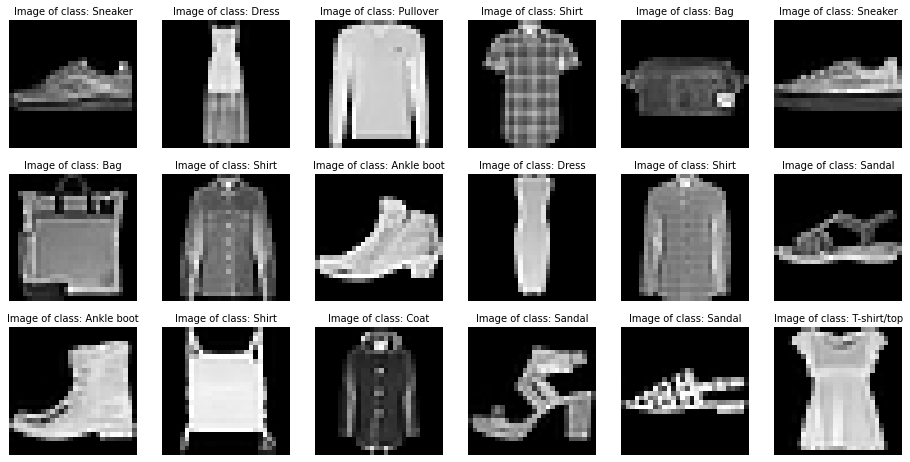

In [5]:
# Lest read a random image from the dataset and draw it
from random import randrange
fig  = plt.figure(figsize=(16, 8))
for i in range(3):
    for j in range(6):
        plt.subplot2grid((3, 6), (i, j))
        image, label = training_data[randrange(1000)]
        plt.imshow(image[0], 'gray')
        plt.axis('off')
        plt.title(f'Image of class: {training_data.classes[label]}', fontsize=10)

In [6]:
# Lets check image shape
image.shape

torch.Size([1, 28, 28])

In [7]:
# Lets see all the classes available
training_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Task 1:

Create a DataLoader objects for train and test

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([28, 28])
torch.Size([])


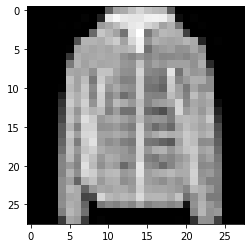

Label: 4


In [8]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#dir(train_dataloader)
train_features, train_labels = next(iter(train_dataloader))
print(type(train_features), type(train_labels))
img = train_features[0].squeeze()
label = train_labels[0]
print(img.shape)
print(label.shape)
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

# Task 2:

Create a Neural Network

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, tensor):
        tensor = self.flatten(tensor)
        out = self.model(tensor)
        return out
    
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=10, bias=True)
    (9): LogSoftmax(dim=1)
  )
)


# Task 3:

Specify loss and optimizer

In [12]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Task 3:

Train model using for loop

In [13]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}, progress:  [{100 * (current/size):>0.2f}% / 100%]')


def test_model(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Accuracy: {(100 * correct):>0.1f}%\n')
    
epochs = 10
for e in range(epochs):
    print(f'Epoch {e+1}\n------------------------------------------')
    train_loop(train_dataloader, model, criterion, optimizer)
    test_model(test_dataloader, model, criterion)
    
print('Finished!')

Epoch 1
------------------------------------------
loss: 2.292431, progress:  [0.00% / 100%]
loss: 0.539577, progress:  [10.67% / 100%]
loss: 0.375959, progress:  [21.33% / 100%]
loss: 0.707446, progress:  [32.00% / 100%]
loss: 0.530716, progress:  [42.67% / 100%]
loss: 0.431049, progress:  [53.33% / 100%]
loss: 0.432658, progress:  [64.00% / 100%]
loss: 0.316002, progress:  [74.67% / 100%]
loss: 0.469867, progress:  [85.33% / 100%]
loss: 0.400081, progress:  [96.00% / 100%]
Accuracy: 84.0%

Epoch 2
------------------------------------------
loss: 0.168718, progress:  [0.00% / 100%]
loss: 0.402629, progress:  [10.67% / 100%]
loss: 0.301640, progress:  [21.33% / 100%]
loss: 0.328552, progress:  [32.00% / 100%]
loss: 0.226271, progress:  [42.67% / 100%]
loss: 0.481627, progress:  [53.33% / 100%]
loss: 0.277001, progress:  [64.00% / 100%]
loss: 0.580721, progress:  [74.67% / 100%]
loss: 0.359552, progress:  [85.33% / 100%]
loss: 0.345140, progress:  [96.00% / 100%]
Accuracy: 85.5%

Epoch 

# Task 4:

Report accuracy from train set, and test set independently

In [14]:
predictions = torch.Tensor([]).to(device)
labels = torch.Tensor([]).to(device)

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model.forward(X)
        predictions = torch.cat((predictions, preds), 0)
        labels = torch.cat((labels, y), 0)
        
_, preds = torch.max(predictions, dim=1)
pred_labels = (preds == labels).float().sum()
accuracy =  pred_labels / len(labels)
print(f'Test accuracy: {accuracy:>0.3}%')  

Test accuracy: 0.884%


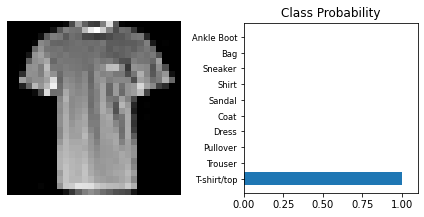

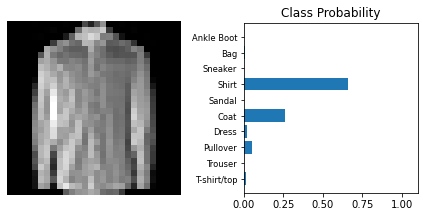

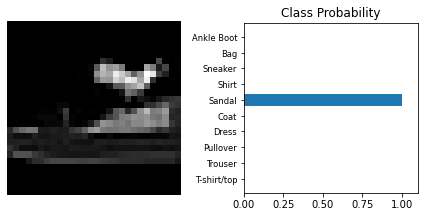

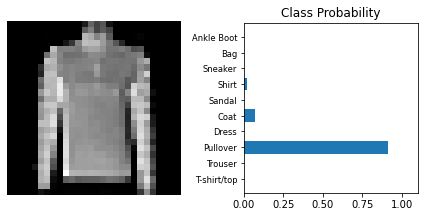

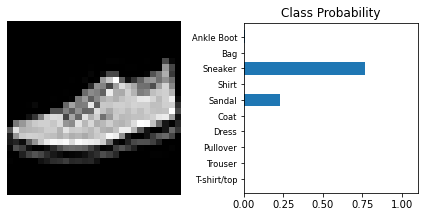

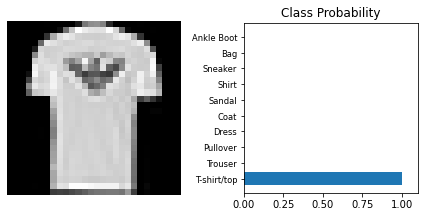

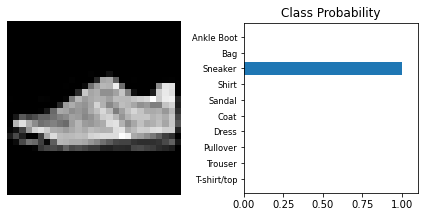

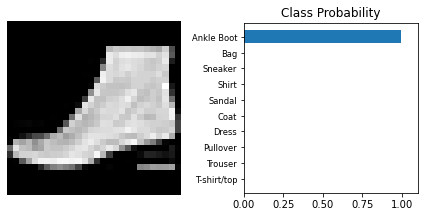

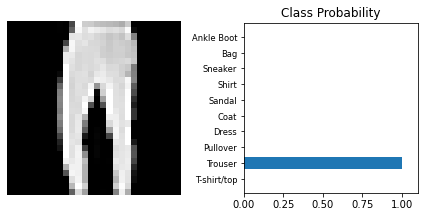

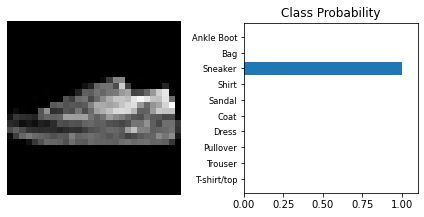

In [15]:
def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img[0], 'gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

dataiter = iter(test_dataloader)
for _ in range(10):
    images, labels = dataiter.next()
    img = images[0]
    img = img.resize_(1, 784)

    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    view_classify(img.resize_(1, 28, 28), ps)

# Task 5:

Report confussion matrix for the test set

Expected format:
```
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
```

In [22]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(labels, preds)
print('Confusion matrix \n', conf_matrix)

Confusion matrix 
 [[910   0  15  15   3   0  41   0  16   0]
 [  1 957   2  33   4   0   2   0   1   0]
 [ 22   0 778  11 112   0  71   0   6   0]
 [ 33   3   7 884  51   0  16   0   6   0]
 [  0   0  91  19 847   0  39   0   4   0]
 [  0   0   0   0   0 975   0  17   0   8]
 [204   0  77  32  82   0 585   0  20   0]
 [  0   0   0   0   0  18   0 963   0  19]
 [  2   0   2   4   2   2   1   3 984   0]
 [  0   0   0   0   0  12   1  34   0 953]]


# Task 6 (optional):

Train LogisticRegression and DecisionTree models on the same data
Compare their performance to the NN